In [1]:

from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/HDFS

/content/drive/MyDrive/HDFS


In [3]:
from IPython.display import clear_output
!pip install drain3
clear_output()

In [4]:
import numpy as np
import pandas as pd
from datetime import datetime , timedelta
from sklearn.cluster import KMeans
from drain3 import TemplateMiner
from drain3.file_persistence import FilePersistence
import numpy as np
# Drain3 persistence
persistence = FilePersistence("drain3_state.json")
template_miner = TemplateMiner(persistence)

records = []

with open("HDFS.log", "r") as f:
    for idx, line in enumerate(f, start=1):
        line = line.strip()
        if not line:
            continue
        result = template_miner.add_log_message(line)
        records.append({"line_id": idx, "log": line, "cluster_id": result["cluster_id"]})

df = pd.DataFrame(records)

In [5]:
# Final template map
cluster_map = {c.cluster_id: c.get_template() for c in template_miner.drain.clusters}
for r in records:
    r["template"] = cluster_map.get(r["cluster_id"], None)

df = pd.DataFrame(records)
df.drop(columns=["cluster_id"], inplace=True)
# Parametreleri çıkar

In [6]:
df_unique_examples = df.groupby("template").first().reset_index()
for cluster in template_miner.drain.clusters:
    print(cluster)

ID=1     : size=3046841   : <*> <*> INFO dfs.DataNode$DataXceiver: Receiving block <*> src: <*> dest: <*>
ID=2     : size=1016956   : <*> <*> INFO dfs.FSNamesystem: BLOCK* NameSystem.allocateBlock: <*> <*>
ID=3     : size=3016253   : <*> <*> INFO dfs.DataNode$PacketResponder: PacketResponder <*> for block <*> <*>
ID=4     : size=3015852   : <*> <*> INFO dfs.DataNode$PacketResponder: Received block <*> of size <*> from <*>
ID=5     : size=3037985   : <*> <*> INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: <*> is added to <*> size <*>
ID=6     : size=12396     : <*> <*> INFO dfs.DataNode$DataXceiver: Received block <*> src: <*> dest: <*> of size <*>
ID=7     : size=12105     : <*> <*> INFO dfs.DataNode$DataTransfer: <*> block <*> to <*>
ID=8     : size=300       : <*> <*> INFO dfs.DataNode: <*> Starting thread to transfer block <*> to <*> <*>
ID=9     : size=300       : <*> 19 INFO dfs.FSNamesystem: BLOCK* ask <*> to replicate <*> to datanode(s) <*> <*>
ID=10  

# Extract Params With LLM

Çalıştırabilmek için GEMINI_API_KEY bulundurmak gerekir

In [7]:
from tqdm import tqdm
prompt = """
Prompt:
You are an AI agent that extracts parameters from log templates.
I will provide you with:
A raw log line.
Its corresponding log template.
The log template contains <*> placeholders (masks). Your task is to return an array of parameter types in the same order that the <*> appear.
Allowed parameter types (keys):
USER
DATETIME
IP
DURATION
BLKNO
Example:
Log: 081111 092742 25457 INFO dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_-5952182400333241163 terminating
Template: <*> <*> <*> dfs.DataNode$PacketResponder: PacketResponder 1 for block blk_<*> terminating
Output: {{DATETIME,*,*,BLKNO}}
Instructions:

Only use the keys listed above. If paramater does not match any key write * in its place

Before Giving output always make a analyse for each "<*>" word in the template and its correspondig word in the log.

Only Analyse "<*>" word dont analyze other words e.g. [ID],[USER]

Must always key count have to be equal to Template's * count

Always return the output in the format: {{KEY, KEY, ...}}

Now process the following:
Log: {log}
Template: {template}

Output:
"""
from google import genai
import os
from dotenv import load_dotenv

# Path to your .env file
load_dotenv('/content/drive/MyDrive/Mylog/.env')
client = genai.Client()



In [ ]:
results = {}

for idx, row in (df_unique_examples.iterrows()) :
  template = row["template"]
  log = row["log"]
  i = 0
  while i < 5 :
    try :
      response = client.models.generate_content(
        model="gemini-2.5-flash",
        contents=prompt.format(log = log , template=template),
      )
      break
    except :
      print(f"failed trying again : {i}. attempt" )
      results.update({template : "failed"})
      i+=1
  print(response.text)
  print("---------------------------------------------------------------------------------------------------------------------------------------------")
  print("--------------------{}---------------".format(template))
  results.update({template : response.text.split("{")[1].split("}")[0]})

In [ ]:
results_df = pd.DataFrame(results.items(), columns=["template", "result"])
results_df

NameError: name 'results' is not defined

In [ ]:
from tqdm import tqdm
for idx, row in tqdm(df.iterrows()):
    template = row["template"]
    log_line = row["log"]
    params = template_miner.extract_parameters(template, log_line, exact_matching=True)  # ->
    param_list = results_df[results_df['template']== template]['result'].values[0].split(",") # -> ['DAY', 'TIME', '*', '*', 'USER', '*', 'IP', 'IP', 'IP', 'DURATION', '*', '*']

    param_list = [param.strip() for param in param_list]

    for p_idx , param_type in enumerate(param_list) :
      if param_type != "*" :
        df.at[idx, param_type] = params[p_idx].value


248163it [02:19, 1780.02it/s]


IndexError: list index out of range

In [ ]:
from sklearn.preprocessing import LabelEncoder
import torch.nn as nn

# Map usernames to integer IDs
user_encoder = LabelEncoder()
df["user_id"] = user_encoder.fit_transform(df["USER"].fillna("UNK"))

# Template Embedding (template2vec)

In [ ]:
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from sklearn.metrics.pairwise import cosine_similarity


# ========== Step 2: Generate BERT embeddings ==========
class BertEmbedder:
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        self.model.eval()

    def get_template_vector(self, template_text):
        tokens = self.tokenizer(template_text, return_tensors="pt", padding=True, truncation=True, max_length=64)
        with torch.no_grad():
            outputs = self.model(**tokens)
        cls_embedding = outputs.last_hidden_state[:, 0, :].squeeze().numpy()
        return cls_embedding

# ========== Example Usage ==========
templates = df["template"].unique()

# Step 1: Build word table
embedder = BertEmbedder()
template_vectors = {}
for t in templates:
    template_vectors[t] = embedder.get_template_vector(t)



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# Date Encoder param2vec

## Day and Time to Date

In [ ]:
import numpy as np
for idx,row in df.iterrows() :
  date = row["DATE"]
  df.at[idx,"date"] = datetime.strptime(date, "%y%m%d %H%M%S")
df.drop(columns=["DAY","TIME"] , inplace= True)

## TIME encode

In [ ]:
import numpy as np
from datetime import datetime

def time_encoding(value, max_value):
    """Cyclic encoding for a single time unit."""
    angle = 2 * np.pi * value / max_value
    return np.array([np.sin(angle), np.cos(angle)])

def encode_time(time : str) :
    """
    Encode a time string into a cyclic time vector.
    Units: hour, minute, second
    time : %H:%M:%S
    """
    if ":" in time :
      hour , minute , second = map(int , time.split(":"))
    else :
      second = int(time)
      hour = 0
      minute = 0
    encoded = []
    encoded.append(time_encoding(hour , 24))
    encoded.append(time_encoding(minute , 60))
    encoded.append(time_encoding(second , 60))
    return np.concatenate(encoded)

def encode_datetime(dt: datetime):
    """
    Encode a datetime object into a cyclic time vector.
    Units: month, day, hour, minute, second, microsecond (millisecond-level).
    """
    if pd.isna(dt):
        return np.full(12, np.nan) # Return NaN array for missing values
    encoded = []
    # Month (1–12)
    encoded.append(time_encoding(dt.month, 12))
    # Day of month (1–31, rough upper bound)
    encoded.append(time_encoding(dt.day, 31))
    # Hour (0–23)
    encoded.append(time_encoding(dt.hour, 24))
    # Minute (0–59)
    encoded.append(time_encoding(dt.minute, 60))
    # Second (0–59)
    encoded.append(time_encoding(dt.second, 60))
    # Millisecond (0–999 from microsecond field)
    ms = dt.microsecond // 1000
    encoded.append(time_encoding(ms, 1000))

    # Concatenate into one feature vector
    return np.concatenate(encoded)


template_embeds = []
date_embeds = []
connection_time_embeds = []
for idx, row in df.iterrows():
    template = row["template"]
    template_embeds.append(template_vectors[template])

    date_embeds.append(encode_datetime(row["date"]))
    if pd.isna(row["DURATION"]) == False:
      con_time = row["DURATION"]
      if type(con_time) is str   :
        if ":" in con_time :
          conntection_time_sec = (int(con_time.split(":")[0]) * 3600) + (int(con_time.split(":")[1]) * 60) + (int(con_time.split(":")[2]))
          df.at[idx,"DURATION"] = conntection_time_sec
      else :
        df.at[idx,"DURATION"] = int(con_time)

df["template_embed"] = template_embeds
df["date_embed"] = date_embeds

## Connection_Time Embedding

In [ ]:
from sklearn.preprocessing import StandardScaler
duration = df["DURATION"].fillna(0).astype(float).values.reshape(-1, 1)

# 2. StandardScaler nesnesini oluşturun.
duration_scaler = StandardScaler()

# 3. Scaler'ı SADECE EĞİTİM VERİSİ üzerinden eğitin (fit).
#    Bu adım, eğitim verisinin ortalamasını ve standart sapmasını öğrenir.
duration_scaler.fit(duration)

# 4. Hem eğitim hem de test verisini öğrendiğiniz bu değerlerle dönüştürün (transform).
df["duration_scaled"] = duration_scaler.transform(duration)

# Yeni sütunumuzun adı 'duration_scaled' ve bu sütun tek bir sayı içeriyor.

In [ ]:
df["combined_embed"] = df.apply(
    lambda row: np.concatenate([row["template_embed"], row["date_embed"], np.array([row["duration_scaled"]]).reshape(1,)]),
    axis=1
)

In [ ]:
df["combined_embed"]

,combined_embed
0,"[-0.21102800965309143, -0.15260635316371918, 0..."
1,"[-0.10966666042804718, -0.04685284569859505, 0..."
2,"[-0.21102800965309143, -0.15260635316371918, 0..."
3,"[-0.10966666042804718, -0.04685284569859505, 0..."
4,"[-0.21102800965309143, -0.15260635316371918, 0..."
...,...
771,"[-0.522854208946228, -0.2799355983734131, -0.0..."
772,"[-0.522854208946228, -0.2799355983734131, -0.0..."
773,"[-0.522854208946228, -0.2799355983734131, -0.0..."
774,"[-0.522854208946228, -0.2799355983734131, -0.0..."


# BILSTM With Sliding Window

## Create Sliding Window

In [ ]:
df = df.sample(frac=1).reset_index(drop=True)

window_size = 20  # template window, or adjust
sequences = []
n = len(df)
train_end = int(n * 0.8)

df_train = df.iloc[:train_end]
df_test  = df.iloc[train_end:]

df_train.sort_values(by="date", inplace=True)
df_test.sort_values(by="date", inplace=True)

def make_windows(data, window_size=10):
    X, Y, U = [], [], []
    for i in range(len(data) - window_size):
        # input: window of embeddings
        X.append(np.stack(data["combined_embed"].iloc[i:i+window_size]))
        # target: next template embedding
        Y.append(data["combined_embed"].iloc[i+window_size])
        # user: ID of the target log
        U.append(data["user_id"].iloc[i+window_size])
    return np.array(X), np.array(Y), np.array(U)


X_train, Y_train ,U_train   = make_windows(df_train)
X_test,  Y_test , U_test    = make_windows(df_test)



/tmp/ipython-input-3082556815.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.sort_values(by="date", inplace=True)
/tmp/ipython-input-3082556815.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.sort_values(by="date", inplace=True)


In [ ]:
import torch
mu = X_train.mean(axis=(0,1), keepdims=True)   # shape: (1,1,embed_dim)
sigma = X_train.std(axis=(0,1), keepdims=True) + 1e-8

X_train_norm = (X_train - mu) / sigma
X_test_norm  = (X_test  - mu) / sigma

template_dim = df_train["template_embed"].iloc[0].shape[0]  # 768

# compute mu and sigma for template embeddings only
mu_y = Y_train.mean(axis=0, keepdims=True)      # shape (1, template_dim)
sigma_y = Y_train.std(axis=0, keepdims=True) + 1e-8

Y_train_norm = (Y_train - mu_y) / sigma_y
Y_test_norm  = (Y_test  - mu_y) / sigma_y

X_train_t = torch.tensor(X_train_norm, dtype=torch.float32)
Y_train_t = torch.tensor(Y_train_norm, dtype=torch.float32)

U_train_t = torch.tensor(U_train, dtype=torch.long)
U_test_t  = torch.tensor(U_test, dtype=torch.long)

X_test_t = torch.tensor(X_test_norm, dtype=torch.float32)
Y_test_t  = torch.tensor(Y_test_norm, dtype=torch.float32)

In [ ]:
class Attention(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.attn = nn.Linear(hidden_dim*2, hidden_dim)
        self.v = nn.Linear(hidden_dim, 1, bias=False)

    def forward(self, lstm_out):
        # lstm_out: (batch, seq_len, hidden*2)
        energy = torch.tanh(self.attn(lstm_out))   # (batch, seq_len, hidden)
        scores = self.v(energy).squeeze(-1)        # (batch, seq_len)
        attn_weights = torch.softmax(scores, dim=1).unsqueeze(-1)  # (batch, seq_len, 1)

        context = torch.sum(attn_weights * lstm_out, dim=1)  # (batch, hidden*2)
        return context, attn_weights

In [ ]:
class LogBiLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, num_layers=1,
                 output_dim=None):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=num_layers, batch_first=True, bidirectional=True)
        self.attention = Attention(hidden_dim)
        self.output_dim = output_dim
        if output_dim:
            self.fc = nn.Linear(hidden_dim*2, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        context, attn_weights = self.attention(lstm_out)
        if self.output_dim:
            out = self.fc(context)
            return out, attn_weights
        return context, attn_weights

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(torch.tensor(X_train_t, dtype=torch.float32),
                              torch.tensor(Y_train_t, dtype=torch.float32),
                               torch.tensor(U_train_t, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False)


/tmp/ipython-input-1710453892.py:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_dataset = TensorDataset(torch.tensor(X_train_t, dtype=torch.float32),
/tmp/ipython-input-1710453892.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(Y_train_t, dtype=torch.float32),
/tmp/ipython-input-1710453892.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch.tensor(U_train_t, dtype=torch.long))


In [ ]:
model = LogBiLSTM(input_dim=X_train_t.shape[2], hidden_dim=256, output_dim=781 )

In [ ]:

import torch
import torch.nn as nn
import matplotlib.pyplot as plt

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 150
attn_records = []  # attention ağırlıklarını kaydetmek için

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    for i, (X_batch, Y_batch, user_batch) in enumerate(train_loader):
        optimizer.zero_grad()
        output, attn_weights = model(X_batch)  # attention dönüyor

        loss = criterion(output, Y_batch)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_loss += loss.item()

        # sadece ilk batch’in ilk örneğini kaydedelim (fazla yer kaplamasın diye)
        if i == 10:
          print("recorded")
          attn_records.append(attn_weights[0].detach().cpu().numpy())

    print(f"Epoch {epoch+1}, Train Loss: {total_loss/len(train_loader):.4f}")


Epoch 98, Train Loss: 0.2303
Epoch 99, Train Loss: 0.2274
Epoch 100, Train Loss: 0.2205
Epoch 101, Train Loss: 0.2175
Epoch 102, Train Loss: 0.2131
Epoch 103, Train Loss: 0.2097
Epoch 104, Train Loss: 0.2097
Epoch 105, Train Loss: 0.2024
Epoch 106, Train Loss: 0.1976
Epoch 107, Train Loss: 0.1949
Epoch 108, Train Loss: 0.1933
Epoch 109, Train Loss: 0.1911
Epoch 110, Train Loss: 0.1867
Epoch 111, Train Loss: 0.1831
Epoch 112, Train Loss: 0.1812
Epoch 113, Train Loss: 0.1801
Epoch 114, Train Loss: 0.1878
Epoch 115, Train Loss: 0.1915
Epoch 116, Train Loss: 0.1966
Epoch 117, Train Loss: 0.2289
Epoch 118, Train Loss: 0.2133
Epoch 119, Train Loss: 0.2059
Epoch 120, Train Loss: 0.2089
Epoch 121, Train Loss: 0.2060
Epoch 122, Train Loss: 0.2006
Epoch 123, Train Loss: 0.1912
Epoch 124, Train Loss: 0.1899
Epoch 125, Train Loss: 0.1876
Epoch 126, Train Loss: 0.1830
Epoch 127, Train Loss: 0.1791
Epoch 128, Train Loss: 0.1774
Epoch 129, Train Loss: 0.1748
Epoch 130, Train Loss: 0.1720
Epoch 131, T

In [ ]:
model.eval()
with torch.no_grad():
    test_output, attn_weights = model(X_test_t )
    errors = ((test_output - Y_test_t) ** 2).mean(dim=1)  # shape: (num_windows,)


In [ ]:
# # Her epoch için kaydedilen attention ağırlıklarını çiz
# for epoch, attn in enumerate(attn_records, 1):
#     plt.figure(figsize=(10, 3))
#     plt.bar(range(len(attn)), attn.squeeze())  # sequence uzunluğu kadar sütun
#     plt.title(f"Epoch {epoch} - Attention distribution (first sample)")
#     plt.xlabel("Sequence position (token index)")
#     plt.ylabel("Attention weight")
#     plt.show()



In [ ]:
import numpy as np

def explain_anomaly_v2(idx, test_output, Y_test_t ):
    """
    Bir anomaliyi, özellik bazında tahmin hatasını (MSE) hesaplayarak açıklar.

    Args:
        idx (int): Test setindeki anomalinin indeksi.
        test_output (torch.Tensor): Modelin test seti için yaptığı tüm tahminler.
        Y_test_t (torch.Tensor): Test setinin gerçek değerleri.

    Returns:
        tuple: (Hata sözlüğü, Açıklama metni)
    """
    # 1. DOĞRU KARŞILAŞTIRMA: Test tahminini, test gerçeğiyle karşılaştır.
    diff = (test_output[idx] - Y_train_t[idx]).cpu().numpy()

    # 2. GÜNCEL BOYUTLAR: 'duration' özelliğini 1 boyutlu olarak güncelleyin.
    #    (Eğer hala 6 boyutlu 'connection' kullanıyorsanız, burayı eski haliyle bırakın)
    sizes = {"template": 768, "date": 12, "duration": 1}

    start = 0
    errors_mse = {}
    for feature_name, size in sizes.items():
        # Vektörün ilgili kısmını al
        part = diff[start:start + size]

        # 3. NORMALİZE EDİLMİŞ HATA: L2 norm yerine Ortalama Karesel Hata (MSE) hesapla.
        #    Bu, boyut etkisini ortadan kaldırır.
        errors_mse[feature_name] = np.mean(np.square(part))

        start += size

    # En yüksek ortalama hataya sahip olan özelliği bul
    main_feature = max(errors_mse, key=errors_mse.get)

    # Daha detaylı bir açıklama metni oluştur
    explanation = (
        f"Bu log penceresi anormal çünkü '{main_feature}' özelliğinin tahmini "
        f"beklenenden çok farklı.\n"
        f"Özellik bazında ortalama hata (MSE): {errors_mse}"
    )

    return errors_mse, explanation


In [ ]:
threshold = errors.mean() + 2 * errors.std()
anomalies_idx = torch.where(errors > threshold)[0]  # indices of anomalous windows
for i in range(len(anomalies_idx)):
  idx = anomalies_idx[i]
  errories, reason = explain_anomaly_v2(idx, test_output, Y_test_t )
  print(errories)   # her feature için hata büyüklüğü
  print("\n")
  print(reason)   # açıklama
  print("\n")
  print(df_test.iloc[int(idx)]['log'])
  print("---------------------------------------------------------------------------")


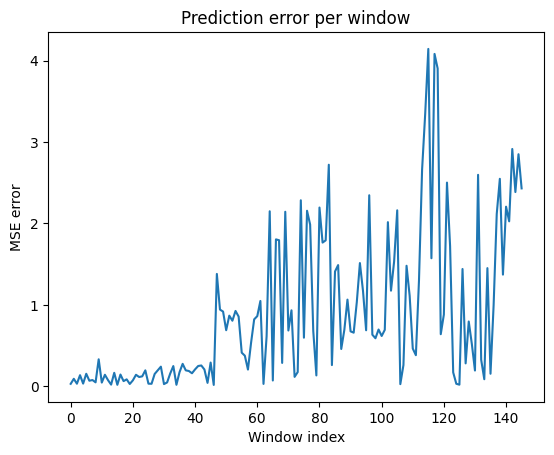

Anomalous windows: tensor([114, 115, 117, 118, 142, 144])


In [ ]:
import matplotlib.pyplot as plt

plt.plot(errors.numpy())
plt.xlabel("Window index")
plt.ylabel("MSE error")
plt.title("Prediction error per window")
plt.show()

# Simple threshold for anomalies
threshold = errors.mean() + 2*errors.std()
anomalies = torch.where(errors > threshold)[0]
print("Anomalous windows:", anomalies)

In [ ]:
# df_test is the test DataFrame
anomalous_logs = df_train.iloc[anomalies_idx]



## Neden Bunlar anomali olarak değerlendirildiler.